### Data Preprocessing

The following steps are very crucial for data analysis:
> * Assigning numerical values to categorical data
> * Handling missing values
> * Normalizing the features


#### Step1: Importing the libaries

In [188]:
%matplotlib inline 

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from scipy.stats import norm
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('white')
plt.rcParams['figure.figsize'] = (8, 4)

#### Step2: Importing the data set 
Importing the dataset with Group lable and dividing the dataset into X and y components for data analysis

In [189]:
data = pd.read_csv("../../Result/Profile/CRC_HC_species.csv", index_col=False)
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data.set_index('SampleID').sort_values(by='Group', ascending=False)

X = data.iloc[:, 1:data.shape[1]].values
y = data.iloc[:, 0].values

#### Step3: Transforming the string label into interge label

* 1 = HC = Healthy Control
* 0 = CRC = Colorectal Cancer

In [190]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

**the HC group is represented as class 1, and the CRC group is represented as class 0, respectively**

#### Step4: Feature Standardization

* Normalizing the data into a standard Gaussion distribution with a mean of 0 and a standard deviation of 1 is very useful when perform the machine learning algorithms
* The species' profile of relative abundance is sparse matrix, which has a differing distributions.

In [191]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
Xs = scaler.fit_transform(X)
Xs

array([[ 1.66026037, -0.32164245, -0.39238926, ..., -0.36287234,
        -0.35509836, -0.32908974],
       [ 1.05279883,  1.52174577, -0.27249563, ..., -0.36287234,
        -0.35509836, -0.32908974],
       [ 1.43151977, -0.32681857, -0.33270139, ..., -0.36287234,
        -0.35509836, -0.32908974],
       ...,
       [-0.66819751,  0.04204048, -0.39238926, ...,  0.28014594,
         0.46598024, -0.32908974],
       [-0.53705736, -0.30631363,  0.61694715, ..., -0.36287234,
        -0.35509836,  0.60825506],
       [ 0.4985386 , -0.32452076,  0.11249892, ..., -0.36287234,
        -0.35509836,  1.93818158]])

#### Step5: Splitting the dataset into Train set and Test set 

* Data partition with 70% train and 30% test set
* Model built on train set 
* Performance of model on the test set

In [192]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(Xs, y, test_size=0.2, random_state=7)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1104, 110), (1104,), (276, 110), (276,))

#### Step6.1: Dimensionality Reduciton with Principal Coordinate Analysis 

In [331]:
import numpy as np
import pandas as pd
from sklearn import manifold
import scipy.stats
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import itertools

def Jaccard(X):
    '''
    compute Jaccard similarity and then convert it into distance by subtracting it from 1.0.
    Args:
      X: input N x K data matrix. N ... the number of samples, K ... the number of features.
    Return:
      N x N data matrix. The value of (i,j) shows the distance between sample-i and sample-j.
    '''
    X = np.array(X)
    n_samples = X.shape[0]
    n_distance = n_samples * (n_samples - 1) / 2
    d_array = np.zeros(int(n_distance))
    for i, (idx1, idx2) in enumerate(itertools.combinations(range(n_samples),2)):
        v1_nonzero_index = np.flatnonzero(X[idx1])
        v2_nonzero_index = np.flatnonzero(X[idx2])
        intersection = len(np.intersect1d(v1_nonzero_index, v2_nonzero_index))
        union = len(np.union1d(v1_nonzero_index, v2_nonzero_index))
        d_array[i] = 1.0 - (float(intersection) / float(union))
    
    return squareform(d_array)


def BrayCurtis(X):
    '''
    compute Bray-Curtis dissimilarity.
    Args:
      X: input N x K data matrix. N ... the number of samples, K ... the number of features.
    Return:
      N x N data matrix. The value of (i,j) shows the distance between sample-i and sample-j.
    '''
    from scipy.spatial.distance import braycurtis
    
    X = np.array(X)
    n_samples = X.shape[0]
    n_distance = n_samples * (n_samples - 1) / 2
    d_array = np.zeros(int(n_distance))
    for i, (idx1, idx2) in enumerate(itertools.combinations(range(n_samples),2)):
        d_array[i] = braycurtis(X[idx1], X[idx2])
    
    return squareform(d_array)


def executePCoA(data, distance_metric, drawBiplot, n_arrows, groupfile):
    '''
    Visualization for PCoA
    Args:
      data: matrix data file. rows are variables, columns are samples.
      distance_metric: distance metric used for PCoA.
      drawBiplot: biplot with calculating factor loadings
      n_arrows: top-contributing features
      groupfile: first columns are sample names, second columns are group names
    Return:
      PCoA plot
    '''
    
    matrix = data.values
    n_features, n_samples = matrix.shape
    print(n_features, 'features, ', n_samples, 'samples')
    
    # compute distance
    if distance_metric == 'Jaccard':
        distance_matrix = Jaccard(matrix.T)
    elif distance_metric == 'BrayCurtis':
        distance_matrix = BrayCurtis(matrix.T)
    
    # execute PCoA
    mds = manifold.MDS(n_components=2, max_iter=100, dissimilarity="precomputed", n_jobs=1)
    positions = mds.fit(distance_matrix).embedding_
    positions_with_sampleIndex = pd.DataFrame(positions, index=data.columns)
    
    # General settings of the canvas
    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_position(('data', 0))
    ax.spines['left'].set_position(('data', 0))
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    
    if drawBiplot:
        circle = plt.Circle((0,0), radius=1.0, fc='none', linestyle='dashed', color='gray')
        ax.add_patch(circle)
        # compute correlations between feature vectors and data points.
        cor_pc1 = np.array([0.]*n_features)
        cor_pc2 = np.array([0.]*n_features)
        arrow_length = np.array([0.]*n_features)
        for i,current_feature in enumerate(data.index):
            x = scipy.stats.pearsonr( data.loc[current_feature].values, positions[:,0] )[0]
            y = scipy.stats.pearsonr( data.loc[current_feature].values, positions[:,1] )[0]
            cor_pc1[i] = x
            cor_pc2[i] = y
            arrow_length[i] = np.sqrt( x**2 + y**2 )
        arrows = pd.DataFrame( np.hstack(( np.matrix(cor_pc1).T, np.matrix(cor_pc2).T, np.matrix(arrow_length).T )), index=data.index, columns=['x','y','len'])
        sorted_arrows = arrows.sort_values(by=['len'], ascending=False)
        # Top-{n_arrows} contributing features are drawed
        for name in sorted_arrows.index[:arrows.shape[0]]:
            ax.arrow(0.0,0.0, arrows.loc[name,'x'], arrows.loc[name,'y'], ec='k', alpha=0.2)
            ax.annotate(name, xy=(arrows.loc[name,'x'], arrows.loc[name,'y']), xytext=(0,0), textcoords='offset points', color='k', fontsize=10)
    
    # draw plots using colors if samples are binned into groups
    if groupfile.empty == False:
        group_names = []
        group2sample = {}
        sample2group = dict(groupfile.values)
        for sample, group in sample2group.items():
            if group in group2sample.keys():
                group2sample[group].append(sample)
            else:
                group2sample[group] = [sample]
                group_names.append(group)
        colors = itertools.cycle(['r','g','b','c','m','y','k'])
        markers = itertools.cycle(['o','^','s','*','x'])
        for i, current_group in enumerate(group_names):
            if len(group2sample[current_group]) == 0:
                continue
            ax.scatter(positions_with_sampleIndex.loc[group2sample[current_group], 0],
                       positions_with_sampleIndex.loc[group2sample[current_group], 1],
                       s=100, marker=next(markers), color=next(colors), label='Group-%s'%current_group)
        plt.legend(bbox_to_anchor=(0., 1.01, 1., 1.01), loc=3, ncol=6, mode="expand", borderaxespad=0.)
    else:
        for i,sample_name in enumerate(data.columns):
            ax.annotate(sample_name, xy=(positions[i,0],positions[i,1]), xytext=(5,5), textcoords='offset points', color='k', fontsize=16)
        ax.scatter(positions[:,0], positions[:,1], c='k', s=50)
    
    x_label = 'PCoA1'
    y_label = 'PCoA2'
    ax.annotate(x_label, xy=(0.0, -1.0), xytext=(0.0,-40.0), textcoords='offset points', ha='center', color='k', fontsize=18)
    ax.annotate(y_label, xy=(-1.0, 0.0), xytext=(-40.0,0.0), textcoords='offset points', ha='center', color='k', fontsize=18, rotation=90)
    fig.show()

110 features,  1380 samples


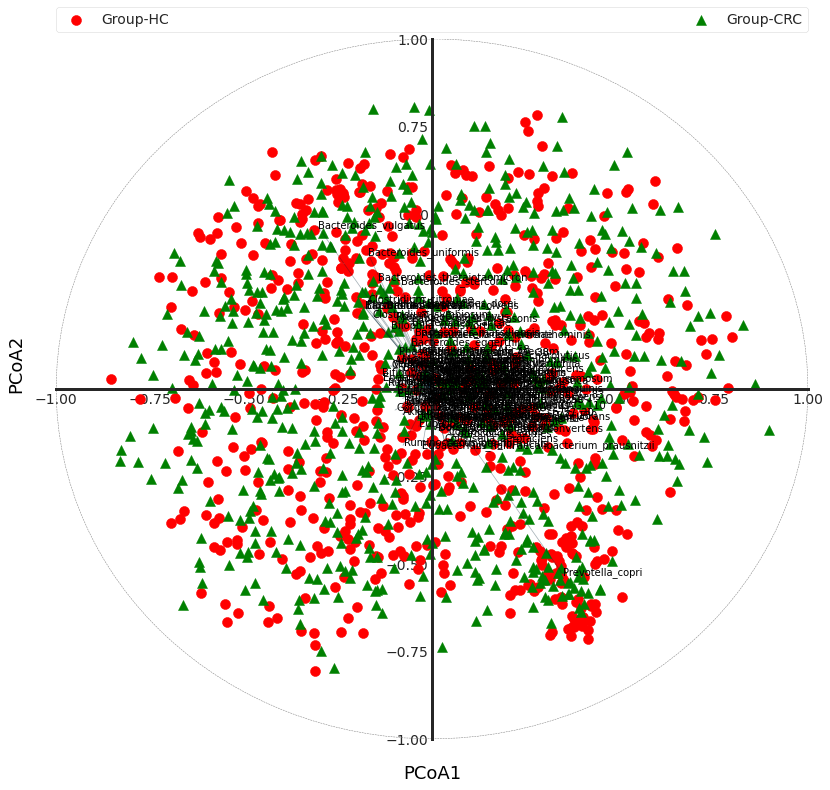

In [332]:
dat_prof = data.iloc[:, 1:data.shape[1]].T
dat_phen = data.loc[:, ['Group']].rename_axis("SampleID").reset_index()
executePCoA(dat_prof, "BrayCurtis", True, 5, dat_phen)

#### Step6.2: Dimensionality Reduciton with Principal Component Analysis 

In [333]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
fit = pca.fit(Xs)
Xs_pca = pca.transform(Xs)

print("Explained Variance: %s" % fit.explained_variance_ratio_)

Explained Variance: [0.05722889 0.04971971 0.03391486 0.02926472 0.02239428 0.02052037
 0.01719728 0.01692838 0.01628667 0.0152472 ]


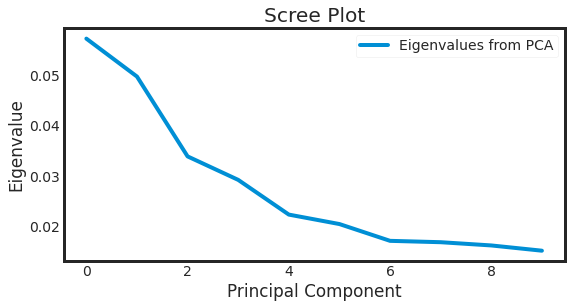

In [334]:
#The amount of variance that each PC explains
var = pca.explained_variance_ratio_

plt.plot(var)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')

leg = plt.legend(['Eigenvalues from PCA'], loc='best', borderpad=0.3,shadow=False,markerscale=0.4)
leg.get_frame().set_alpha(0.4)
leg.set_draggable(state=True)
plt.show()

> The most obvious change in slope in the scree plot occurs at component 2, which is the "elbow" of the scree plot. Therefore, it could be argued based on the basis of the scree plot that the first three components should be retained.

In [335]:
import numpy as np
from sklearn.decomposition import PCA

def biplotPCA(reduced_data, labels, variable):
    
    '''
    plot compositional biplot for two principal components
    Args:
        reduced_data: data processed by PCA
        labels:       labels of the original dataset
        variable:     the names of the variables of the data set     
    '''
    
    plt.figure(figsize=(12, 8))
    
    legend = []
    classes = np.unique(labels)
    n = reduced_data.shape[1]
    colors = ['r', 'b']
    
    x = reduced_data[:, 0]
    y = reduced_data[:, 1]
    scalex = 1.0/(x.max() - x.min())
    scaley = 1.0/(y.max() - y.min())
    
    # Scatter plot with a two-dimensional plot using normal PCA
    for i, label in enumerate(classes):
        plt.scatter(x[labels==label] * scalex,
                    y[labels==label] * scaley,
                    linewidth=0.01,
                    c=colors[i])
        legend.append("Group: {}".format(label))
    plt.legend(legend)
    
    # plot arrows as the variable contribution, each variable has a score for PCA1 and PCA2 respectively
    for i in range(n):
        plt.arrow(0, 0, reduced_data[0, i], reduced_data[1, i], color='k', alpha=0.7, linewidth=1)
        plt.text(reduced_data[0, i]*1.01, reduced_data[1, i]*1.01, variable[i], ha='center', va='center', color='k', fontsize=12)
    
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.title('Compositional biplot')
    plt.grid()
    plt.show()



def Static3Dplot(reduced_data, labels, variable):
    
    '''
    draw a static compositional biplot in 3d for three principal components
    Args:
        reduced_data: data processed by PCA
        labels:       labels of the original dataset
        variable:     the names of the variables of the data set     
    '''
    
    fig = plt.figure(figsize=(14, 10))
    ax = plt.axes(projection='3d')
    
    legend = []
    classes = np.unique(labels)
    n = reduced_data.shape[1]
    colors = ['r', 'b']
    
    x = reduced_data[:, 0]
    y = reduced_data[:, 1]
    z = reduced_data[:, 2]
    scalex = 1.0/(x.max() - x.min())
    scaley = 1.0/(y.max() - y.min())
    scalez = 1.0/(z.max() - z.min())
    
    # Scatter plot with a two-dimensional plot using normal PCA
    for i, label in enumerate(classes):
        ax.scatter3D(x[labels==label] * scalex,
                     y[labels==label] * scaley,
                     z[labels==label] * scalez,
                     linewidth=0.01,
                     c=colors[i])
        legend.append("Group: {}".format(label))
    ax.legend(legend)
    
    # the initial angle to draw the 3d plot
    azim = -60
    elev = 30
    ax.view_init(elev, azim)
    
    # plot arrows as the variable contribution, each variable has a score for PCA1 and PCA2 respectively
    for i in range(n):
        ax.quiver(0, 0, 0, reduced_data[0, i], reduced_data[1, i], reduced_data[2, i], color='k', alpha=0.7, linewidth=1, arrow_length_ratio=0.05)
        ax.text(reduced_data[0, i]*1.1, reduced_data[1, i]*1.1, reduced_data[2, i]*1.1, variable[i], ha='center', va='center', color='k', fontsize=12)
    
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    plt.title('Compositional Plot in 3 Dimension')
    plt.grid()
    plt.show()

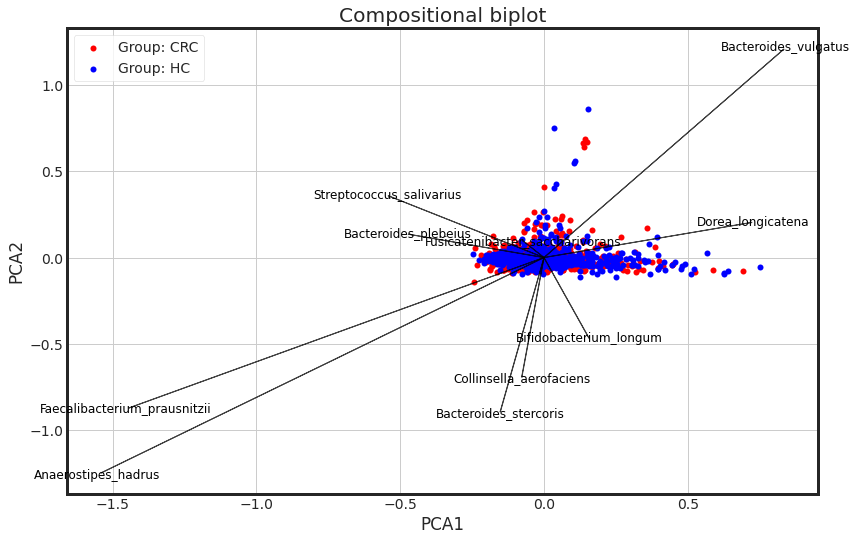

In [186]:
biplotPCA(Xs_pca, data.Group, data.columns[1:data.shape[1]])

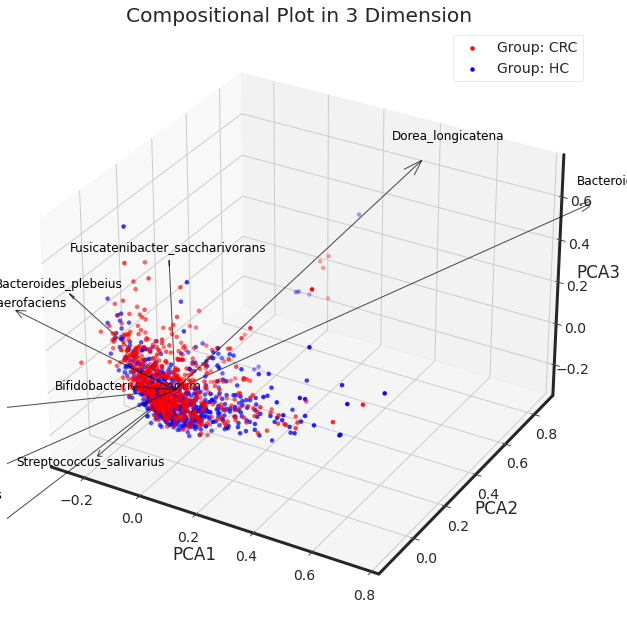

In [219]:
Static3Dplot(Xs_pca, data.Group, data.columns[1:data.shape[1]])

### A Summary of the Data Preprocing Approach used here:

 
>1. assign features to a NumPy array X, and transform the class labels from their original string representation (HC and CRC) into integers
>2. Split data into train set and test sets
>3. Standardize the data.
>4. Obtain the Eigenvectors and Eigenvalues from the covariance matrix or correlation matrix
>5. Sort eigenvalues in descending order and choose the kk eigenvectors that correspond to the kk largest eigenvalues where k is the number of dimensions of the new feature subspace (k≤dk≤d).
>6. Construct the projection matrix W from the selected k eigenvectors.
>7. Transform the original dataset X via W to obtain a k-dimensional feature subspace Y.

### Reference 

1. [python PCoA](https://github.com/mwguthrie/python_PCoA/)